||||||||||||||||||||||||||||||||||||||||    

IEEE Computational Intelligence Society · Research Prediction

**Fraud Detection**

|||||||||||||||||||||||||||||||||||||||||    

Categorical Features - Transaction:
ProductCD,
card1 - card6,
addr1, addr2,
P_emaildomain,
R_emaildomain,
M1 - M9

Categorical Features - Identity:
DeviceType,
DeviceInfo,
id_12 - id_38

# OVERVIEW

# Packages

In [9]:
!pip install missingno ydata-profiling yellowbrick shap

In [10]:
!pip install -U ydata-profiling

import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns

from pathlib import Path
from plotly.subplots import make_subplots
from ydata_profiling import ProfileReport
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, DiscriminationThreshold

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             ConfusionMatrixDisplay,
                             confusion_matrix,
                             classification_report,
                            )
from sklearn.model_selection import (train_test_split,
                                     cross_val_score,
                                     cross_validate,
                                     cross_val_predict,
                                     GridSearchCV,
                                     learning_curve,
                                    )
from sklearn import set_config
set_config(display="diagram", print_changed_only=True)

In [11]:
import os
import random
random.seed(42)
np.random.seed(42)

# 0.Data collection

In [13]:
# set your working directory 

%cd "C:\Users\HP\Desktop\LESLYE\ISEP2\S2\MACHINE_LEARNING\01-ieee-fraud-detection"

[WinError 3] Le chemin d’accès spécifié est introuvable: 'C:\\Users\\HP\\Desktop\\LESLYE\\ISEP2\\S2\\MACHINE_LEARNING\\01-ieee-fraud-detection'
C:\Users\HP\Documents\ISEP2\Semestre2_CT\Informatique\Machine Learning\Projet_ML


In [14]:
## Settings

# Return a new path pointing to the current working directory
HOME_DIR = Path.cwd()

# create a variable for data directory
MODEL_DIR = Path(HOME_DIR, "4_models")

MODEL_DIR.mkdir(parents=True, exist_ok=True)

print(f"Work directory: {HOME_DIR} \nModels directory: {MODEL_DIR}")


Work directory: C:\Users\HP\Documents\ISEP2\Semestre2_CT\Informatique\Machine Learning\Projet_ML 
Models directory: C:\Users\HP\Documents\ISEP2\Semestre2_CT\Informatique\Machine Learning\Projet_ML\4_models


In [15]:
#chargement proprement dite des données 
transaction = pd.read_csv('train_transaction.csv')
identity = pd.read_csv('train_identity.csv')


In [16]:
datasets = {
    "identity": identity,
    "transaction": transaction
}

# Afficher la taille de chaque dataset
for name, df in datasets.items():
    print(f"{name} : {df.shape[0]} lignes, {df.shape[1]} colonnes")

identity : 144233 lignes, 41 colonnes
transaction : 590540 lignes, 394 colonnes


In [17]:
transaction_ids_transaction = set(transaction['TransactionID'].unique())
transaction_ids_identity = set(identity['TransactionID'].unique())

In [18]:
# Vérifier si tous les transactionid de identity sont dans transaction
ids_in_transaction = transaction_ids_identity.issubset(transaction_ids_transaction)

# Vérifier si tous les transactionid de transaction sont dans identity
ids_in_identity = transaction_ids_transaction.issubset(transaction_ids_identity)

print("Tous les transactionid de identity sont-ils dans transaction ? :", ids_in_transaction)
print("Tous les transactionid de transaction sont-ils dans identity ? :", ids_in_identity)


Tous les transactionid de identity sont-ils dans transaction ? : True
Tous les transactionid de transaction sont-ils dans identity ? : False


#  1.Data Cleaning 

In [21]:
identity.isnull().sum()


TransactionID         0
id_01                 0
id_02              3361
id_03             77909
id_04             77909
id_05              7368
id_06              7368
id_07            139078
id_08            139078
id_09             69307
id_10             69307
id_11              3255
id_12                 0
id_13             16913
id_14             64189
id_15              3248
id_16             14893
id_17              4864
id_18             99120
id_19              4915
id_20              4972
id_21            139074
id_22            139064
id_23            139064
id_24            139486
id_25            139101
id_26            139070
id_27            139064
id_28              3255
id_29              3255
id_30             66668
id_31              3951
id_32             66647
id_33             70944
id_34             66428
id_35              3248
id_36              3248
id_37              3248
id_38              3248
DeviceType         3423
DeviceInfo        25567
dtype: int64

In [22]:
identity.describe(include="all")

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
count,1.442330e+05,144233.000000,140872.000000,66324.000000,66324.000000,136865.000000,136865.000000,5155.000000,5155.000000,74926.000000,...,140282,77586.000000,73289,77805,140985,140985,140985,140985,140810,118666
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,130,NaN,260,4,2,2,2,2,2,1786
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,chrome 63.0,NaN,1920x1080,match_status:2,T,F,T,F,desktop,Windows
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22000,NaN,16874,60011,77814,134066,110452,73922,85165,47722
mean,3.236329e+06,-10.170502,174716.584708,0.060189,-0.058938,1.615585,-6.698710,13.285354,-38.600388,0.091023,...,NaN,26.508597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.788496e+05,14.347949,159651.816856,0.598231,0.701015,5.249856,16.491104,11.384207,26.084899,0.983842,...,NaN,3.737502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2.987004e+06,-100.000000,1.000000,-13.000000,-28.000000,-72.000000,-100.000000,-46.000000,-100.000000,-36.000000,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3.077142e+06,-10.000000,67992.000000,0.000000,0.000000,0.000000,-6.000000,5.000000,-48.000000,0.000000,...,NaN,24.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,3.198818e+06,-5.000000,125800.500000,0.000000,0.000000,0.000000,0.000000,14.000000,-34.000000,0.000000,...,NaN,24.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,3.392923e+06,-5.000000,228749.000000,0.000000,0.000000,1.000000,0.000000,22.000000,-23.000000,0.000000,...,NaN,32.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# Valeurs uniques 
def afficher_valeurs_uniques(df, nom_df="DataFrame"):
    print(f"Valeurs uniques par colonne dans {nom_df} :\n")
    for col in df.columns:
        uniques = df[col].unique()
        print(f"Colonne '{col}' ({len(uniques)} valeurs uniques) :")
        print(uniques)
        print("-" * 40)


afficher_valeurs_uniques(identity, "identity")


Valeurs uniques par colonne dans identity :

Colonne 'TransactionID' (144233 valeurs uniques) :
[2987004 2987008 2987010 ... 3577529 3577531 3577534]
----------------------------------------
Colonne 'id_01' (77 valeurs uniques) :
[   0.   -5.  -15.  -10.  -20.  -40.  -30.  -25.  -55.  -45.  -70.  -90.
 -100.  -65.  -60.  -75.  -72.  -50.  -21.  -35.  -85.  -64.  -80.  -95.
  -87.  -58.   -7.  -12.  -11.   -9.  -27.  -42.   -6.  -62.  -18.  -76.
  -23.  -19.  -99.  -13.  -26.  -31.  -17.  -22.  -14.  -34.  -54.  -53.
  -28.  -88.  -16.  -61.  -46.  -94.  -24.  -93.  -44.  -89.  -92.  -37.
  -96.  -57.  -29.  -33.  -32.   -8.  -52.  -43.  -38.  -86.  -47.  -82.
  -48.  -63.  -71.  -56.  -51.]
----------------------------------------
Colonne 'id_02' (115656 valeurs uniques) :
[ 70787.  98945. 191631. ... 172059. 632381.  55528.]
----------------------------------------
Colonne 'id_03' (25 valeurs uniques) :
[ nan   0.   3.   2.   5.   1.   6.   9.   4.  -5.  -9.  -2.  -4.  -1.
  -3.  -7. 

In [24]:
# Fusionner les données
data = pd.merge(transaction, identity, on="TransactionID", how="left")

In [25]:
data.shape

(590540, 434)

In [26]:
# Nombre total de cellules dans la base
total_cells = data.size

# Nombre total de valeurs manquantes
total_missing = data.isnull().sum().sum()

# Pourcentage global de valeurs manquantes
missing_pct_total = (total_missing / total_cells) * 100

print(f"Pourcentage global de valeurs manquantes : {missing_pct_total:.2f}%")

Pourcentage global de valeurs manquantes : 45.07%


In [27]:
# y'a t'il des lignes valeurs manquantes?
missing_rows = data[data.isnull().all(axis=1)]

In [28]:
missing_rows

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo


In [29]:
# libérer la mémoire
del identity
del transaction


## View

In [31]:
def afficher_modalites(df):
    for col in df.columns:
        modalites = df[col].unique()
        print(f"\nVariable : '{col}'")
        print(f"Nombre de modalités : {len(modalites)}")
        print("Modalités :", modalites)

# Utilisation
afficher_modalites(df)


Variable : 'TransactionID'
Nombre de modalités : 590540
Modalités : [2987000 2987001 2987002 ... 3577537 3577538 3577539]

Variable : 'isFraud'
Nombre de modalités : 2
Modalités : [0 1]

Variable : 'TransactionDT'
Nombre de modalités : 573349
Modalités : [   86400    86401    86469 ... 15811079 15811088 15811131]

Variable : 'TransactionAmt'
Nombre de modalités : 20902
Modalités : [  68.5    29.     59.   ...  557.54 1659.95  400.78]

Variable : 'ProductCD'
Nombre de modalités : 5
Modalités : ['W' 'H' 'C' 'S' 'R']

Variable : 'card1'
Nombre de modalités : 13553
Modalités : [13926  2755  4663 ... 13166  8767 18038]

Variable : 'card2'
Nombre de modalités : 501
Modalités : [ nan 404. 490. 567. 514. 555. 360. 100. 111. 352. 375. 418. 303. 314.
 543. 583. 148. 321. 269. 361. 272. 399. 569. 453. 417. 512. 545. 266.
 114. 481. 452. 547. 383. 170. 343. 556. 285. 562. 302. 264. 558. 500.
 396. 103. 206. 143. 243. 476. 199. 174. 423. 446. 492. 523. 440. 528.
 161. 535. 354. 117. 455. 325. 158.

In [32]:
# voir les variables par types
def count_variable_types(df):
    type_counts = df.dtypes.value_counts()
    print("Nombre de variables par type :")
    for dtype, count in type_counts.items():
        print(f"{dtype} : {count}")


In [33]:
count_variable_types(data)

Nombre de variables par type :
float64 : 399
object : 31
int64 : 4


In [34]:
numeric_cols = df.select_dtypes(include=['int64',  'float64']).columns

In [35]:
numeric_cols

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=380)

In [36]:
categorical_cols = df.select_dtypes(include=['object']).columns

In [37]:
categorical_cols

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'],
      dtype='object')

In [38]:
# Nombre de valeurs uniques dans les colonnes de type 'object'

def inspect_object_columns(df):
    
    print("Nombre de valeurs uniques dans les colonnes de type 'object' :\n")
    object_cols = df.select_dtypes(include=['object']).columns
    for col in object_cols:
        unique_count = df[col].nunique()
        total_count = len(df[col])
        print(f"{col}: {unique_count} valeurs uniques sur {total_count} lignes ")

# f"({100 * unique_count / total_count:.6f}%)"

In [39]:
# Valeurs min et max des colonnes numériques

def inspect_numeric_columns(df):
    print("Valeurs min et max des colonnes numériques :\n")
    numeric_cols = df.select_dtypes(include=['int64', 'int32', 'float64', 'float32']).columns
    for col in numeric_cols:
        print(f"{col}: min = {df[col].min()}, max = {df[col].max()}")

In [40]:
# Percentage of Nan

for col in data.columns:
    print(col,'le nombre de NaN est:',data[col].isnull().sum(),end=" ")
    print('le pourcentage de NaN est:',np.round(data[col].isnull().sum()/data.shape[0]*100,6),'%')

TransactionID le nombre de NaN est: 0 le pourcentage de NaN est: 0.0 %
isFraud le nombre de NaN est: 0 le pourcentage de NaN est: 0.0 %
TransactionDT le nombre de NaN est: 0 le pourcentage de NaN est: 0.0 %
TransactionAmt le nombre de NaN est: 0 le pourcentage de NaN est: 0.0 %
ProductCD le nombre de NaN est: 0 le pourcentage de NaN est: 0.0 %
card1 le nombre de NaN est: 0 le pourcentage de NaN est: 0.0 %
card2 le nombre de NaN est: 8933 le pourcentage de NaN est: 1.512683 %
card3 le nombre de NaN est: 1565 le pourcentage de NaN est: 0.265012 %
card4 le nombre de NaN est: 1577 le pourcentage de NaN est: 0.267044 %
card5 le nombre de NaN est: 4259 le pourcentage de NaN est: 0.721204 %
card6 le nombre de NaN est: 1571 le pourcentage de NaN est: 0.266028 %
addr1 le nombre de NaN est: 65706 le pourcentage de NaN est: 11.126427 %
addr2 le nombre de NaN est: 65706 le pourcentage de NaN est: 11.126427 %
dist1 le nombre de NaN est: 352271 le pourcentage de NaN est: 59.652352 %
dist2 le nombre 

In [41]:
inspect_numeric_columns(data)


Valeurs min et max des colonnes numériques :

TransactionID: min = 2987000, max = 3577539
isFraud: min = 0, max = 1
TransactionDT: min = 86400, max = 15811131
TransactionAmt: min = 0.251, max = 31937.391
card1: min = 1000, max = 18396
card2: min = 100.0, max = 600.0
card3: min = 100.0, max = 231.0
card5: min = 100.0, max = 237.0
addr1: min = 100.0, max = 540.0
addr2: min = 10.0, max = 102.0
dist1: min = 0.0, max = 10286.0
dist2: min = 0.0, max = 11623.0
C1: min = 0.0, max = 4685.0
C2: min = 0.0, max = 5691.0
C3: min = 0.0, max = 26.0
C4: min = 0.0, max = 2253.0
C5: min = 0.0, max = 349.0
C6: min = 0.0, max = 2253.0
C7: min = 0.0, max = 2255.0
C8: min = 0.0, max = 3331.0
C9: min = 0.0, max = 210.0
C10: min = 0.0, max = 3257.0
C11: min = 0.0, max = 3188.0
C12: min = 0.0, max = 3188.0
C13: min = 0.0, max = 2918.0
C14: min = 0.0, max = 1429.0
D1: min = 0.0, max = 640.0
D2: min = 0.0, max = 640.0
D3: min = 0.0, max = 819.0
D4: min = -122.0, max = 869.0
D5: min = 0.0, max = 819.0
D6: min = -

In [42]:
inspect_object_columns(data)

Nombre de valeurs uniques dans les colonnes de type 'object' :

ProductCD: 5 valeurs uniques sur 590540 lignes 
card4: 4 valeurs uniques sur 590540 lignes 
card6: 4 valeurs uniques sur 590540 lignes 
P_emaildomain: 59 valeurs uniques sur 590540 lignes 
R_emaildomain: 60 valeurs uniques sur 590540 lignes 
M1: 2 valeurs uniques sur 590540 lignes 
M2: 2 valeurs uniques sur 590540 lignes 
M3: 2 valeurs uniques sur 590540 lignes 
M4: 3 valeurs uniques sur 590540 lignes 
M5: 2 valeurs uniques sur 590540 lignes 
M6: 2 valeurs uniques sur 590540 lignes 
M7: 2 valeurs uniques sur 590540 lignes 
M8: 2 valeurs uniques sur 590540 lignes 
M9: 2 valeurs uniques sur 590540 lignes 
id_12: 2 valeurs uniques sur 590540 lignes 
id_15: 3 valeurs uniques sur 590540 lignes 
id_16: 2 valeurs uniques sur 590540 lignes 
id_23: 3 valeurs uniques sur 590540 lignes 
id_27: 2 valeurs uniques sur 590540 lignes 
id_28: 2 valeurs uniques sur 590540 lignes 
id_29: 2 valeurs uniques sur 590540 lignes 
id_30: 75 valeurs

## Cleaning

In [44]:
## Imputer par le mode ou par missing les variables categorielles

In [45]:
# 1. Liste des colonnes à traiter
card_cols = [f'card{i}' for i in range(1, 7)]
by_missing = ['id_12','addr1']

# 2. Traitement des variables card (mode)
for col in card_cols:
    if col in data.columns:
        # Conversion en catégoriel
        data[col] = data[col].astype('category')
        
        # Calcul du mode (premier élément si égalité)
        mode_val = data[col].mode()[0] 
        
        # Imputation
        data[col] = data[col].fillna(mode_val)

# 3. Traitement spécifique de id_12 (missing)
for col in by_missing:
    if col in data.columns:
    # Conversion en catégoriel + ajout catégorie
        data[col] = (
            data[col]
            .astype('category')
            .cat.add_categories('missing')
            .fillna('missing')
        )

In [46]:
# Pour card1-card6
print("Valeurs uniques de card1 :", data['card1'].unique())

# Pour id_12
print("Répartition des variables remplacées par missing :")
print(data[by_missing].value_counts(dropna=False))



Valeurs uniques de card1 : [13926, 2755, 4663, 18132, 4497, ..., 7236, 17972, 13166, 8767, 18038]
Length: 13553
Categories (13553, int64): [1000, 1001, 1004, 1005, ..., 18391, 18393, 18395, 18396]
Répartition des variables remplacées par missing :
id_12     addr1  
NotFound  missing    60223
missing   325.0      37545
          204.0      36190
          299.0      35626
          264.0      35551
                     ...  
NotFound  117.0          1
          280.0          1
missing   255.0          1
NotFound  467.0          1
          139.0          1
Name: count, Length: 499, dtype: int64


In [47]:
## Imputer les variables numériques 

In [48]:
# 1. Définition de la fonction de suppression améliorée
def drop_missing_columns(df, seuil=16, types=['number'], exclude_patterns=['id_01', 'card']):
    """
    Supprime les colonnes avec > seuil% de valeurs manquantes
    Exclut les colonnes contenant les motifs spécifiés
    """
    # Sélection des colonnes à analyser
    df_subset = df.select_dtypes(include=types)
    
    # Exclusion des colonnes protégées
    excluded_cols = [col for col in df_subset.columns 
                    if any(pattern in col for pattern in exclude_patterns)]
    df_subset = df_subset.drop(columns=excluded_cols)
    
    # Calcul du % de valeurs manquantes
    missing_percent = df_subset.isnull().mean() * 100
    
    # Sélection des colonnes à supprimer
    to_drop = missing_percent[missing_percent > seuil].index.tolist()
    
    # Suppression effective
    df_clean = df.drop(columns=to_drop)
    
    return df_clean, to_drop

# 2. Application de la fonction
df_clean, dropped = drop_missing_columns(
    data,
    seuil=16,
    types=['number'],
    exclude_patterns=['id_01', 'card']
)
print("Colonnes supprimées :", dropped)


Colonnes supprimées : ['dist1', 'dist2', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D11', 'D12', 'D13', 'D14', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V180', 'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V190', 'V191', 'V192', 'V193', 'V194', 'V195', 'V196', 'V197', 'V198', 'V199', 'V200', 'V201', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V218', 'V219', 'V220', 'V221', 'V222', 'V223', '

In [50]:
# 3. Imputation des valeurs manquantes restantes
num_vars = df_clean.select_dtypes(include=['number'])
missing_percent = num_vars.isnull().mean() * 100

result = pd.DataFrame({
    'Variable': missing_percent.index,
    'MissingPercent': missing_percent.round(5)
})

print("\nAvant imputation :")
print(result)

for col in result['Variable']:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())



Avant imputation :
                      Variable  MissingPercent
TransactionID    TransactionID         0.00000
isFraud                isFraud         0.00000
TransactionDT    TransactionDT         0.00000
TransactionAmt  TransactionAmt         0.00000
addr2                    addr2        11.12643
...                        ...             ...
V318                      V318         0.00203
V319                      V319         0.00203
V320                      V320         0.00203
V321                      V321         0.00203
id_01                    id_01        75.57608

[174 rows x 2 columns]


In [51]:
# 4. Mise à jour du dataset original
data.loc[:, df_clean.columns] = df_clean.values

# 5. Vérification finale
verification = data[df_clean.columns].equals(df_clean)
print("\nVérification de l'intégrité des données :", verification)


Vérification de l'intégrité des données : True


In [52]:
## Supprimer les variables avec un certain pourcentage de NaN

In [53]:
# 1. Colonnes initiales
colonnes_initiales = set(data.columns)

# 2. Colonnes à supprimer explicitement
colonnes_a_supprimer = [
    'TransactionID', 'addr2', 'dist1', 'dist2',
    'P_emaildomain', 'R_emaildomain',
    'DeviceType', 'DeviceInfo'
]

# 3. Supprimer les colonnes D2 à D9, D11 à D14 (D1, D10, D15 conservées)
d_cols = [f'D{i}' for i in range(1, 16) if f'D{i}' not in ['D1', 'D10', 'D15'] and f'D{i}' in data.columns]
colonnes_a_supprimer += d_cols

# 4. Supprimer M1 à M9
m_cols = [f'M{i}' for i in range(1, 10) if f'M{i}' in data.columns]
colonnes_a_supprimer += m_cols

# 5. Supprimer les colonnes 'V' avec plus de 15% de valeurs manquantes
v_cols = [col for col in data.columns if col.startswith('V') and data[col].isna().mean() > 0.15]
colonnes_a_supprimer += v_cols

# 6. Supprimer tous les 'id_' sauf 'id_01' et 'id_12'
id_cols = [col for col in data.columns if col.startswith('id_') and col not in ['id_01', 'id_12']]
colonnes_a_supprimer += id_cols

# 7. Supprimer doublons éventuels
colonnes_a_supprimer = list(set(colonnes_a_supprimer))


In [54]:
# 8. Nettoyage du DataFrame
data= data.drop(columns=colonnes_a_supprimer)

# 9. Comptage
nb_supprimees = len(colonnes_a_supprimer)
nb_restantes = data.shape[1]

In [55]:
print(f" {nb_supprimees} variables supprimées.")
print(f" {nb_restantes} variables restantes dans le DataFrame nettoyé.")

 253 variables supprimées.
 181 variables restantes dans le DataFrame nettoyé.


In [56]:
data.select_dtypes(include=['number']).isnull().all().any()

False

In [57]:
# Nombres de valeurs manquantes totales du dataframe.
data.isnull().sum().sum()

0

In [58]:
def afficher_modalites_variable(df, variable):
    if variable in df.columns:
        modalites = df[variable].unique()
        print(f"\nVariable : '{variable}'")
        print(f"Nombre de modalités : {len(modalites)}")
        print("Modalités :", modalites)
    else:
        print(f"La variable '{variable}' n'existe pas dans le DataFrame.")


In [59]:
afficher_modalites_variable(data, 'addr1')


Variable : 'addr1'
Nombre de modalités : 333
Modalités : [315.0, 325.0, 330.0, 476.0, 420.0, ..., 286.0, 507.0, 457.0, 268.0, 245.0]
Length: 333
Categories (333, object): [100.0, 101.0, 102.0, 104.0, ..., 535.0, 536.0, 540.0, 'missing']


In [60]:
# voir les variables par types
def count_variable_types(df):
    type_counts = df.dtypes.value_counts()
    print("Nombre de variables par type :")
    for dtype, count in type_counts.items():
        print(f"{dtype} : {count}")


In [61]:
count_variable_types(data)

Nombre de variables par type :
float64 : 170
int64 : 2
object : 1
category : 1
category : 1
category : 1
category : 1
category : 1
category : 1
category : 1
category : 1


In [62]:
import numpy as np

def reduce_mem (df, verbose=True):
    """
    Réduit la mémoire utilisée par un DataFrame en convertissant :
    - les colonnes int64 en int32
    - les colonnes object en category (si peu de valeurs uniques)
    
    Paramètres :
    - df : pandas DataFrame à optimiser
    - verbose : affiche la réduction mémoire si True
    
    Retour :
    - df optimisé
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type == 'int64':
            df[col] = df[col].astype(np.int32)
        
        elif col_type == 'object':
           df[col] = df[col].astype('category')
    
    end_mem = df.memory_usage().sum() / 1024**2
    
    if verbose:
        print(f'Mémoire utilisée réduite de {start_mem:.2f} Mo à {end_mem:.2f} Mo '
              f'({100 * (start_mem - end_mem) / start_mem:.1f}% de réduction)')
    
    return df


In [63]:
reduce_mem(data)

Mémoire utilisée réduite de 786.29 Mo à 777.84 Mo (1.1% de réduction)


,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V314,V315,V316,V317,V318,V319,V320,V321,id_01,id_12
0,0,86400,68.50,W,13926,321.0,150.0,discover,142.0,credit,...,0.000000,0.000000,0.0,117.0,0.0,0.000000,0.000000,0.000000,-5.0,missing
1,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,credit,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,-5.0,missing
2,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,debit,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,-5.0,missing
3,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,debit,...,0.000000,0.000000,50.0,1404.0,790.0,0.000000,0.000000,0.000000,-5.0,missing
4,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,credit,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,NotFound
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,0,15811047,49.00,W,6550,321.0,150.0,visa,226.0,debit,...,47.950001,47.950001,0.0,0.0,0.0,0.000000,0.000000,0.000000,-5.0,missing
590536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,debit,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,-5.0,missing
590537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,debit,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,-5.0,missing
590538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,debit,...,669.500000,317.500000,0.0,2234.0,0.0,0.000000,0.000000,0.000000,-5.0,missing


In [64]:
print("Mininum date du dataset:",min(data['TransactionDT']))
print("Maximum date du dataset:",max(data['TransactionDT']))

print("Timespan en jours:",(max(data['TransactionDT'])-min(data['TransactionDT']))/(3600*24))

Mininum date du dataset: 86400
Maximum date du dataset: 15811131
Timespan en jours: 181.99920138888888


In [65]:
# voir si le dataset est croissant dans le temps
is_sorted = data['TransactionDT'].is_monotonic_increasing
print(is_sorted)


True


In [66]:
# Doublons 
print("\nNombre de lignes dupliquées :", data.duplicated().sum())


Nombre de lignes dupliquées : 3


In [67]:
# Enregister le dataframe propre final

# Chemin du dossier
folder_path = './0_data'

# Créer le dossier s'il n'existe pas
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Enregistrer le fichier CSV
data.to_csv(f"{folder_path}/cleaned_train.csv", index=False)


In [68]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.stats import skew, kurtosis
import pandas as pd

# 1. Sélection des variables numériques de `data`
num_cols = data.select_dtypes(include=['number']).columns.tolist()

# 2. Choix du scaler en fonction de la distribution
scaler_mapping = {}

for col in num_cols:
    col_data = data[col].dropna()
    if col_data.nunique() <= 1:
        continue  # Trop peu de variation, inutile de scaler

    skewness = skew(col_data)
    kurt = kurtosis(col_data)
    
    if abs(skewness) < 1 and abs(kurt) < 3:
        scaler_mapping[col] = StandardScaler()
    elif abs(skewness) > 2 or abs(kurt) > 5:
        scaler_mapping[col] = RobustScaler()
    else:
        scaler_mapping[col] = MinMaxScaler()

# 3. Construction du ColumnTransformer
transformers = [
    (f"{col}_scaler", scaler, [col]) for col, scaler in scaler_mapping.items()
]

column_transformer = ColumnTransformer(transformers=transformers)

# 4. Pipeline général (ici uniquement pour la mise à l’échelle)
preprocessing_pipeline = Pipeline([
    ('scaling', column_transformer)
])

# 5. Application du pipeline à `data`
scaled_array = preprocessing_pipeline.fit_transform(data)

# 6. Création du DataFrame des variables standardisées
df_scaled = pd.DataFrame(
    scaled_array,
    columns=[f"{col}_scaled" for col in scaler_mapping],
    index=data.index
)

# Optionnel : fusionner avec les autres colonnes non numériques
df_final = pd.concat([data.drop(columns=scaler_mapping.keys()), df_scaled], axis=1)

# Affichage
print("Dimensions du DataFrame final :", df_final.shape)
print(df_final.head())


Dimensions du DataFrame final : (590540, 181)
  ProductCD  card1  card2  card3       card4  card5   card6  addr1     id_12  \
0         W  13926  321.0  150.0    discover  142.0  credit  315.0   missing   
1         W   2755  404.0  150.0  mastercard  102.0  credit  325.0   missing   
2         W   4663  490.0  150.0        visa  166.0   debit  330.0   missing   
3         W  18132  567.0  150.0  mastercard  117.0   debit  476.0   missing   
4         H   4497  514.0  150.0  mastercard  102.0  credit  420.0  NotFound   

   isFraud_scaled  ...  V313_scaled  V314_scaled  V315_scaled  V316_scaled  \
0             0.0  ...          0.0          0.0          0.0          0.0   
1             0.0  ...          0.0          0.0          0.0          0.0   
2             0.0  ...          0.0          0.0          0.0          0.0   
3             0.0  ...          0.0          0.0          0.0         50.0   
4             0.0  ...          0.0          0.0          0.0          0.0   

   V

# EDA

In [70]:
df_cleaned= data

In [71]:
print(df_cleaned.shape)
df_cleaned.info()
df_cleaned.describe(include='all')
df_cleaned['isFraud'].value_counts(normalize=True)  # proportion de fraude


(590540, 181)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 181 entries, isFraud to id_12
dtypes: category(9), float64(170), int32(2)
memory usage: 777.8 MB


isFraud
0    0.96501
1    0.03499
Name: proportion, dtype: float64

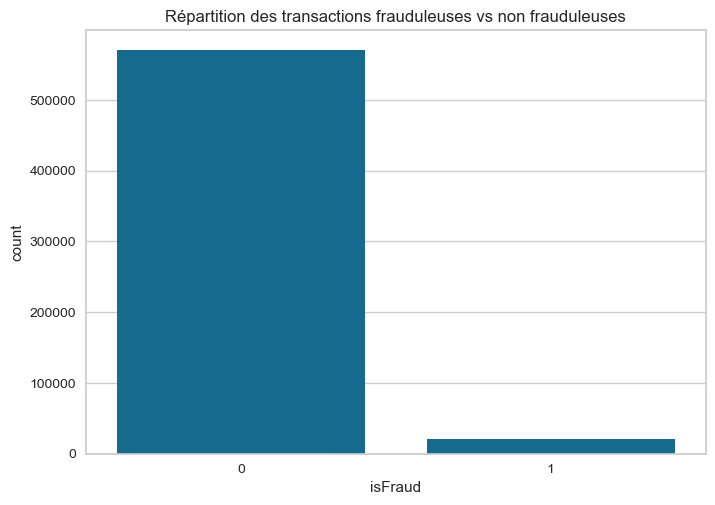

In [136]:
sns.countplot(x='isFraud', data=df_cleaned)
plt.title('Répartition des transactions frauduleuses vs non frauduleuses')
plt.show()


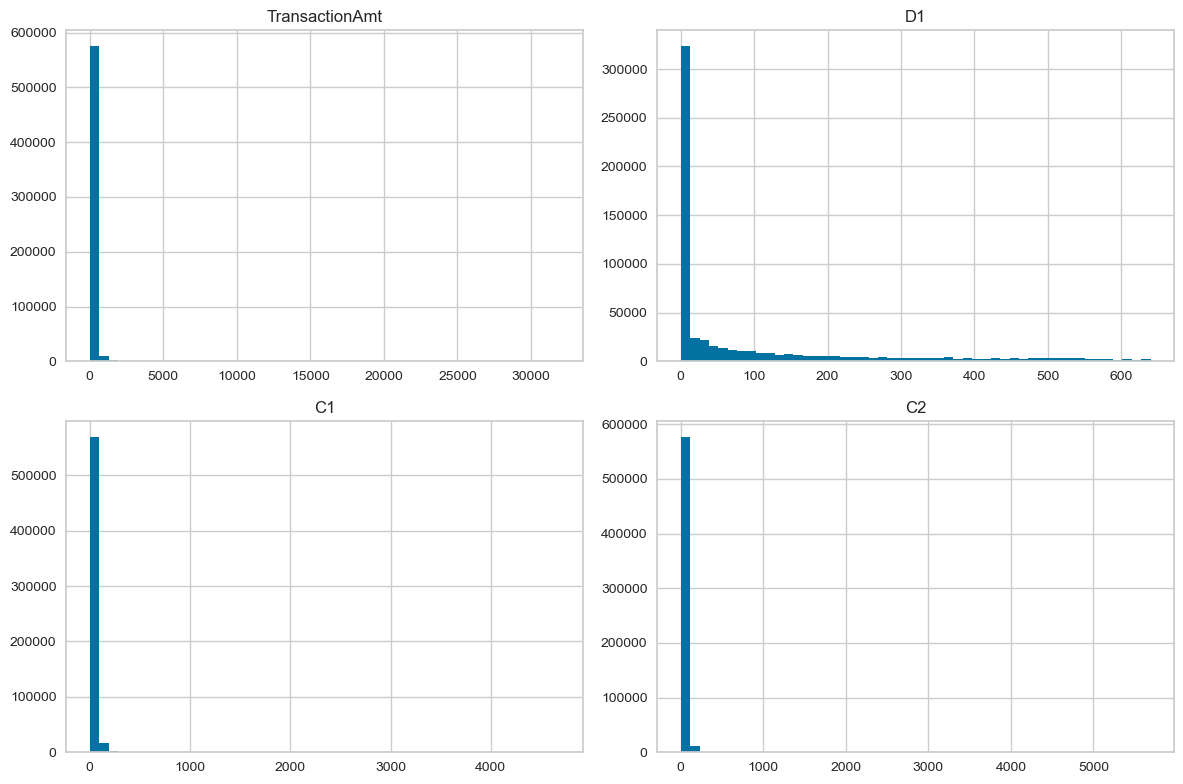

In [137]:
df_cleaned[['TransactionAmt', 'D1', 'C1', 'C2']].hist(bins=50, figsize=(12, 8))
plt.tight_layout()
plt.show()


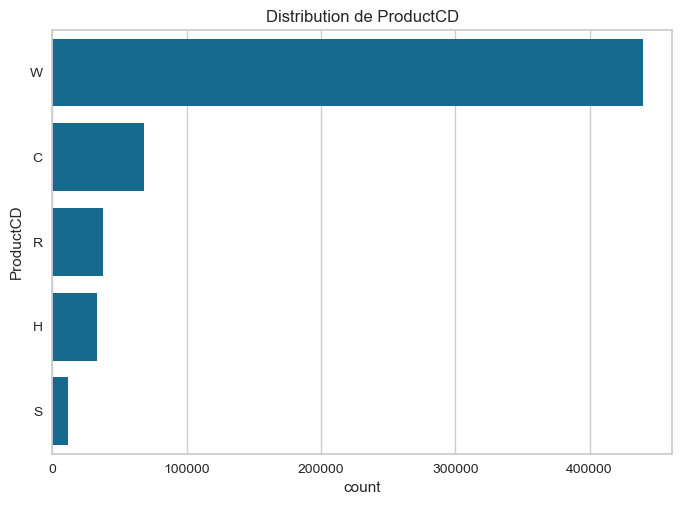

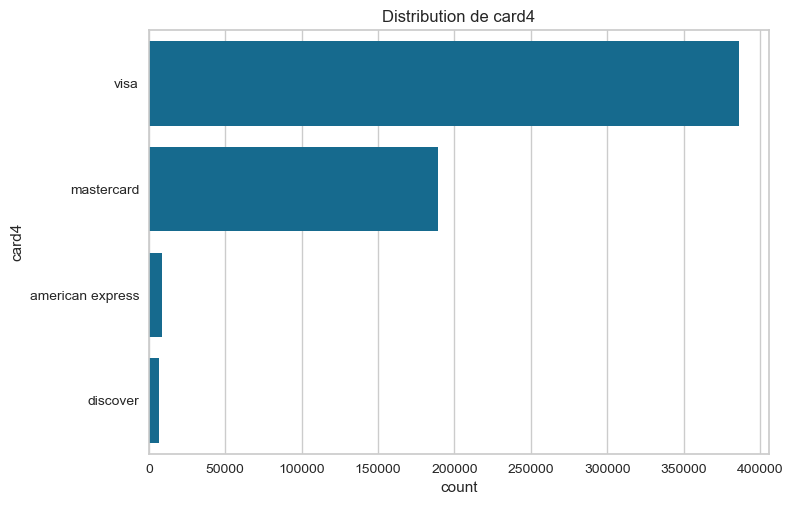

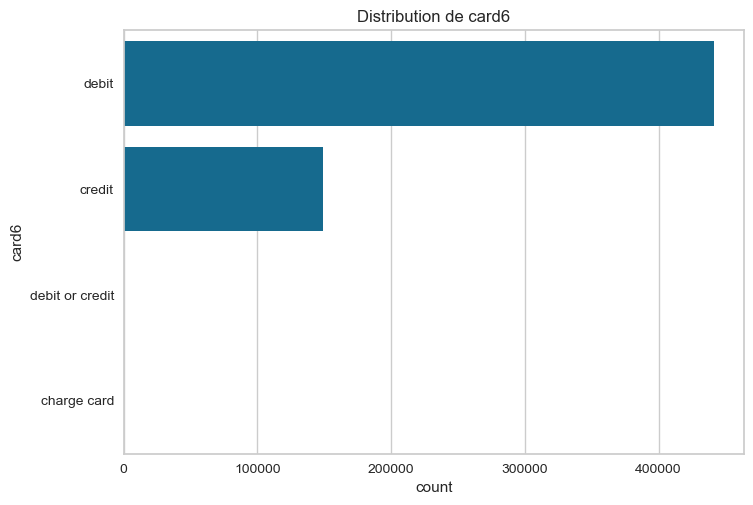

In [138]:
for col in ['ProductCD', 'card4', 'card6']:
    sns.countplot(y=col, data=df_cleaned, order=df_cleaned[col].value_counts().index)
    plt.title(f'Distribution de {col}')
    plt.show()


In [139]:
fraud_rates = df_cleaned.groupby('card4')['isFraud'].mean().sort_values(ascending=False)
print(fraud_rates)


card4
discover            0.077282
visa                0.034720
mastercard          0.034331
american express    0.028698
Name: isFraud, dtype: float64


C:\Users\HP\AppData\Local\Temp\ipykernel_16120\609946259.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rates = df_cleaned.groupby('card4')['isFraud'].mean().sort_values(ascending=False)


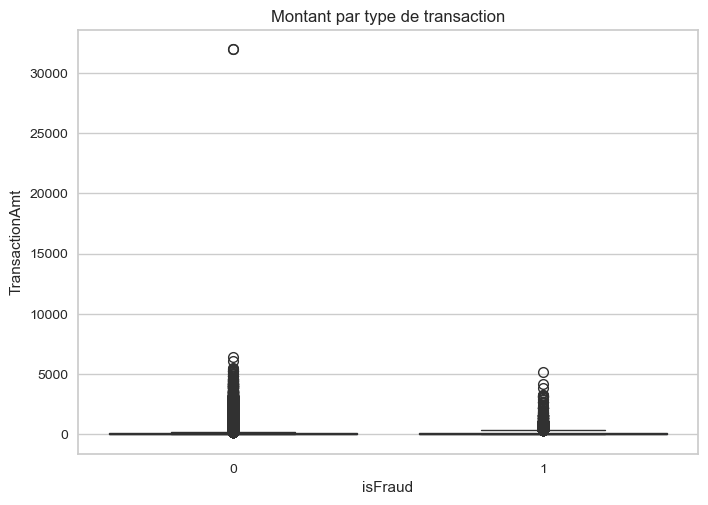

In [140]:
sns.boxplot(x='isFraud', y='TransactionAmt', data=df_cleaned)
plt.title('Montant par type de transaction')
plt.show()


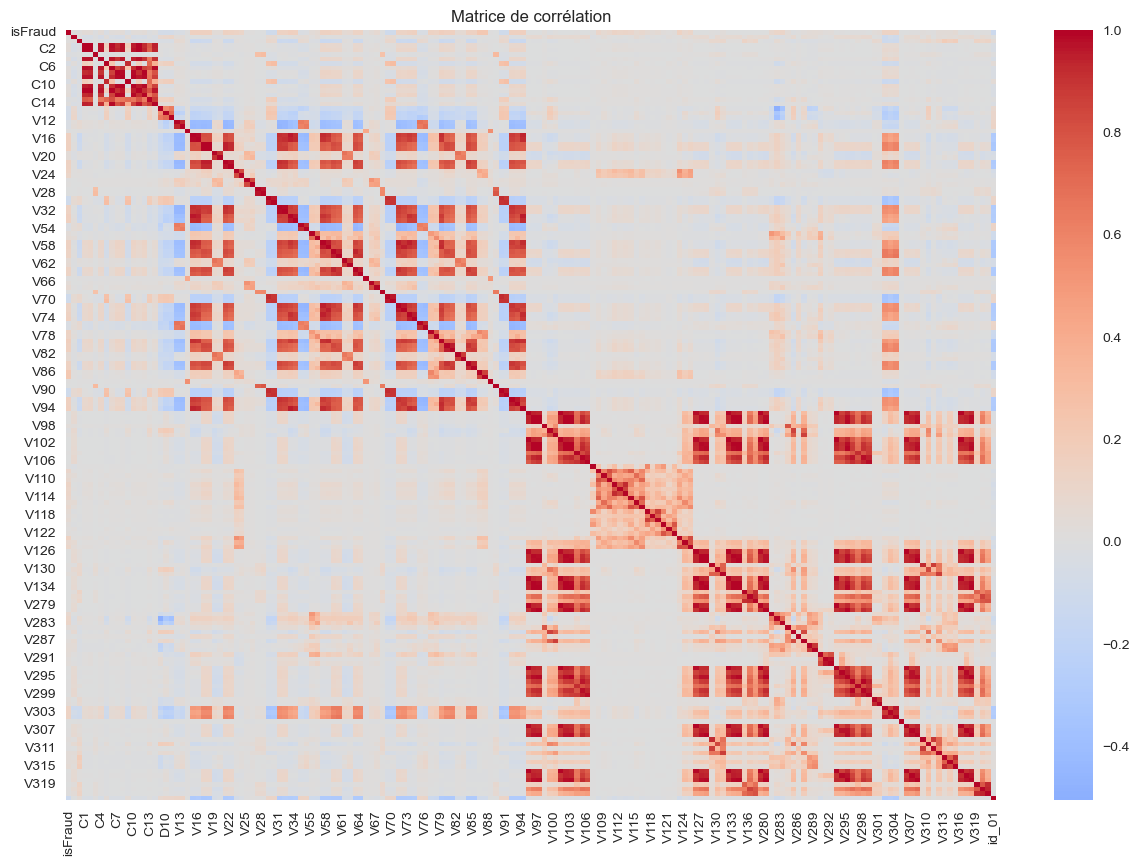

In [141]:
corr_matrix = df_cleaned.corr(numeric_only=True)
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Matrice de corrélation')
plt.show()


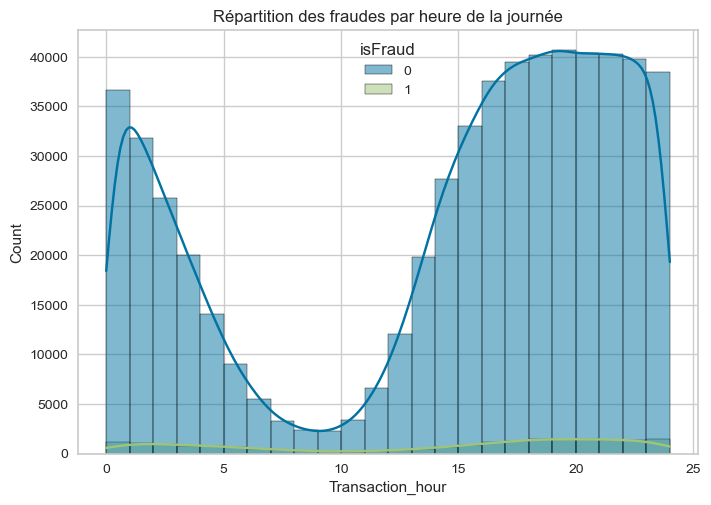

In [142]:
df_cleaned['Transaction_hour'] = (df_cleaned['TransactionDT'] / 3600) % 24
sns.histplot(data=df_cleaned, x='Transaction_hour', hue='isFraud', bins=24, kde=True)
plt.title('Répartition des fraudes par heure de la journée')
plt.show()


13553


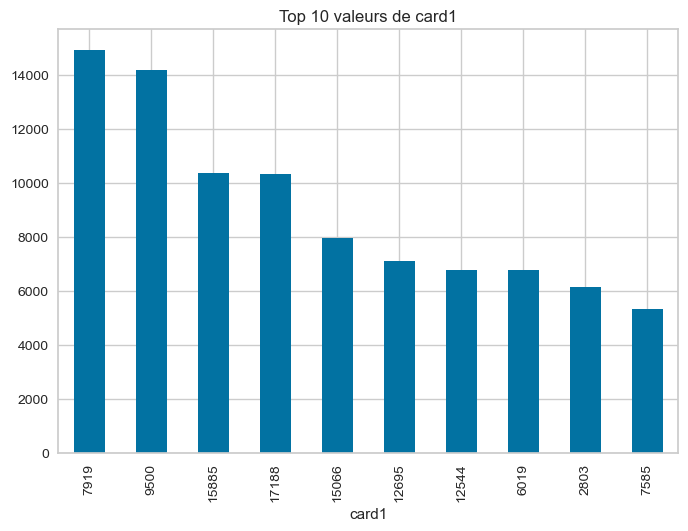

500


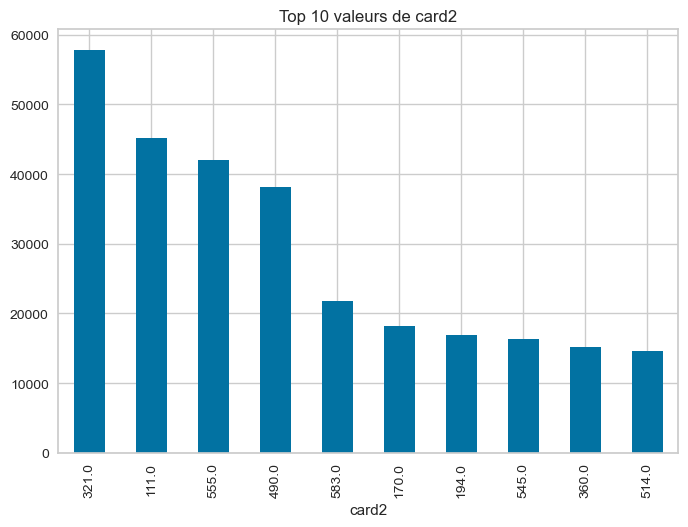

114


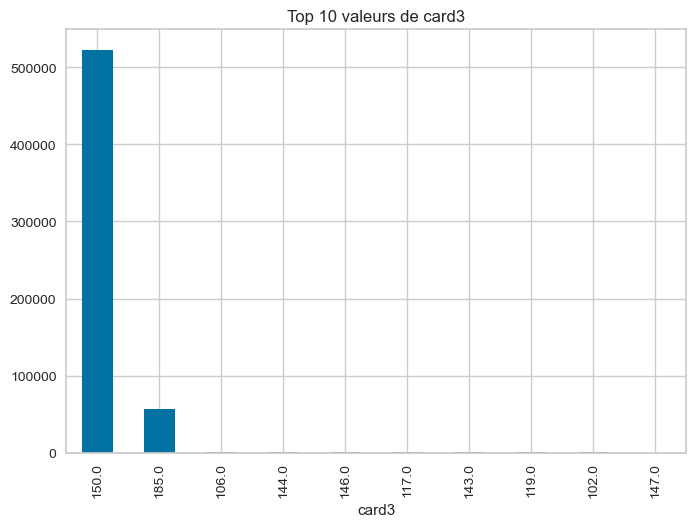

119


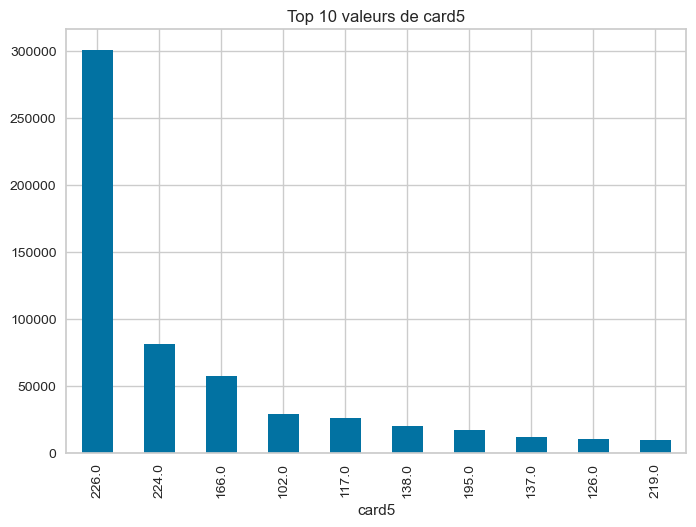

In [143]:
for col in ['card1', 'card2', 'card3', 'card5']:
    print(df_cleaned[col].nunique())  # cardinalité
    df_cleaned[col].value_counts().head(10).plot(kind='bar')
    plt.title(f'Top 10 valeurs de {col}')
    plt.show()


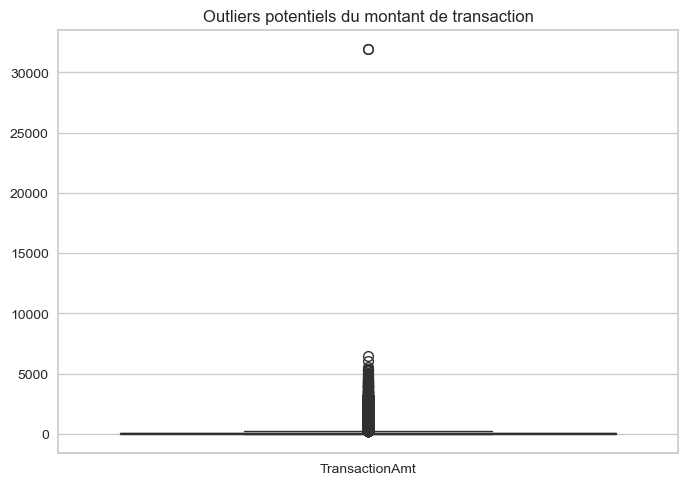

In [144]:
sns.boxplot(data=df_cleaned[['TransactionAmt']])
plt.title('Outliers potentiels du montant de transaction')
plt.show()


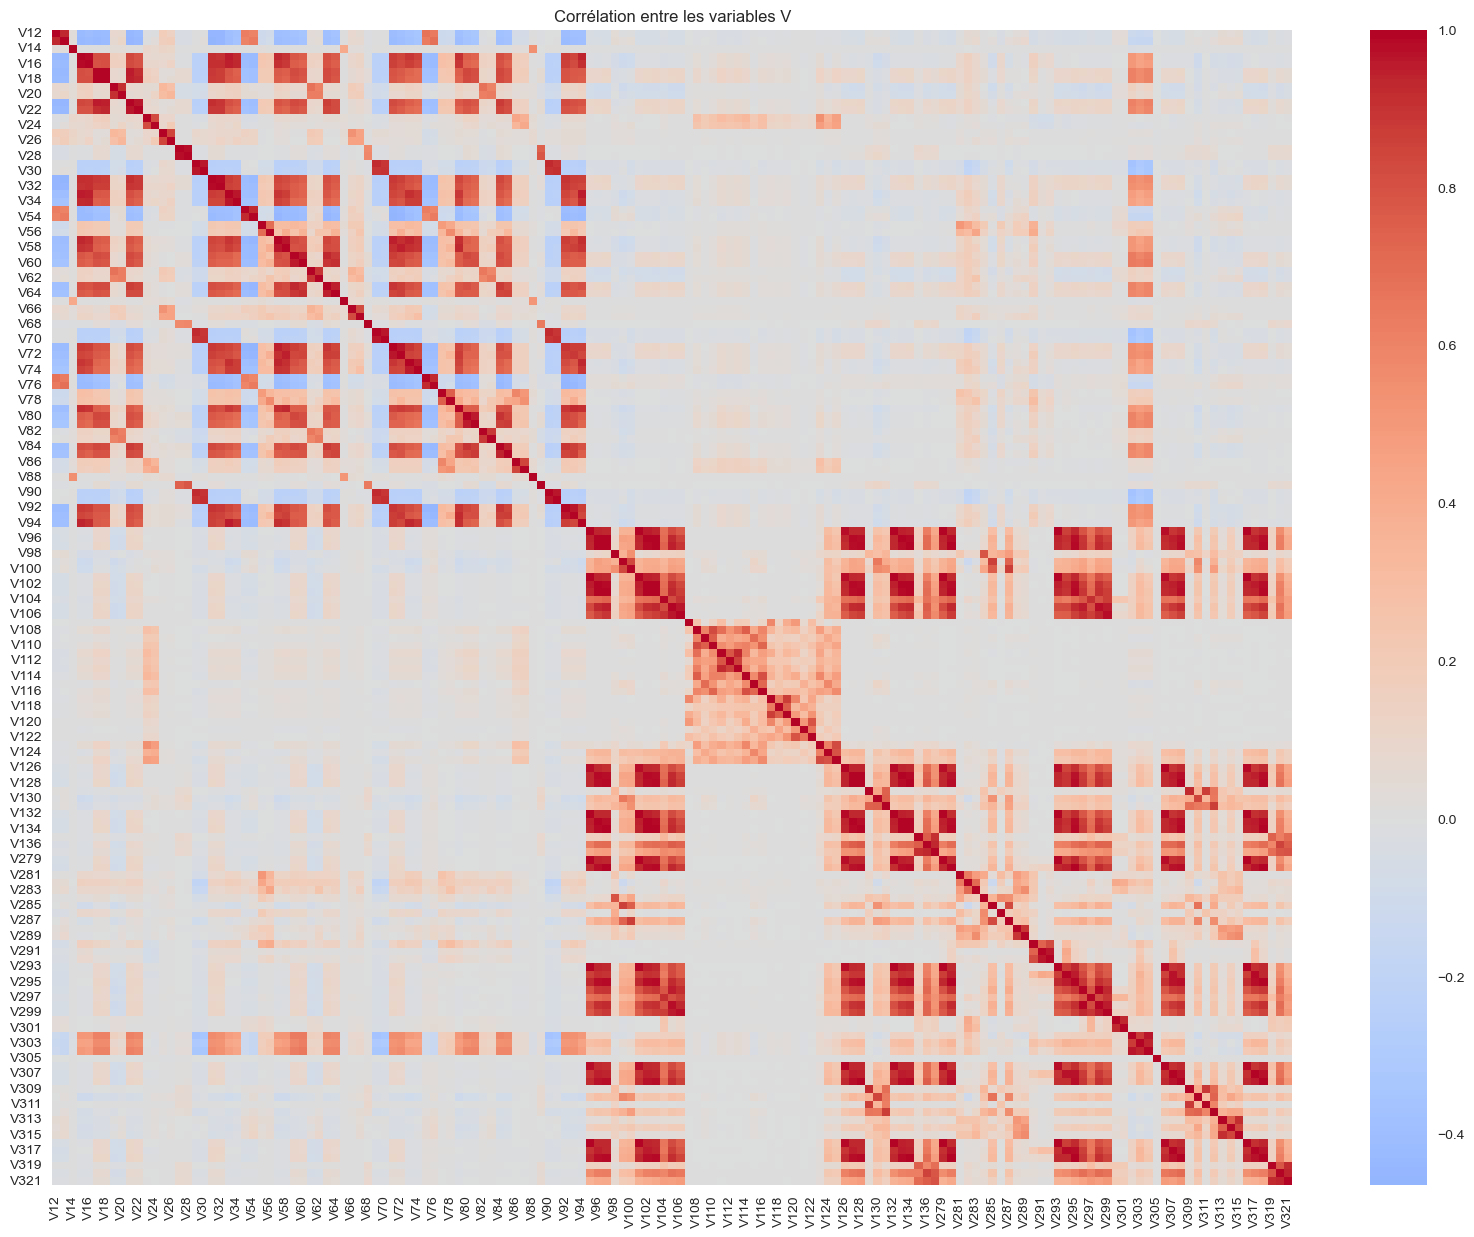

In [145]:
v_cols = [col for col in df_cleaned.columns if col.startswith('V')]
v_df = df_cleaned[v_cols].dropna(axis=1, thresh=int(0.85 * len(df_cleaned)))  # on garde seulement les colonnes V bien remplies

corr_v = v_df.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(corr_v, cmap='coolwarm', center=0)
plt.title("Corrélation entre les variables V")
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_16120\1293572840.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate = filtered_df.groupby(col)['isFraud'].mean().reset_index()
C:\Users\HP\AppData\Local\Temp\ipykernel_16120\1293572840.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fraud_rate, x='isFraud', y=col, palette='viridis')


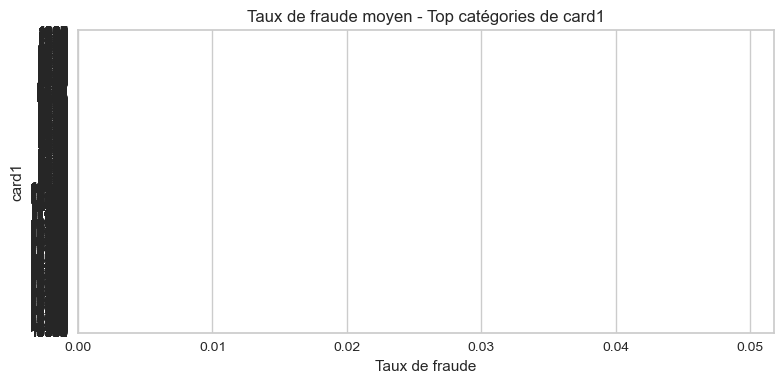

C:\Users\HP\AppData\Local\Temp\ipykernel_16120\1293572840.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate = filtered_df.groupby(col)['isFraud'].mean().reset_index()
C:\Users\HP\AppData\Local\Temp\ipykernel_16120\1293572840.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fraud_rate, x='isFraud', y=col, palette='viridis')


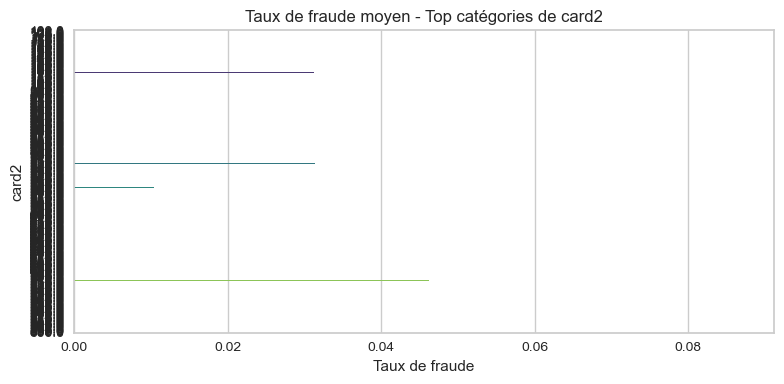

C:\Users\HP\AppData\Local\Temp\ipykernel_16120\1293572840.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate = filtered_df.groupby(col)['isFraud'].mean().reset_index()
C:\Users\HP\AppData\Local\Temp\ipykernel_16120\1293572840.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fraud_rate, x='isFraud', y=col, palette='viridis')


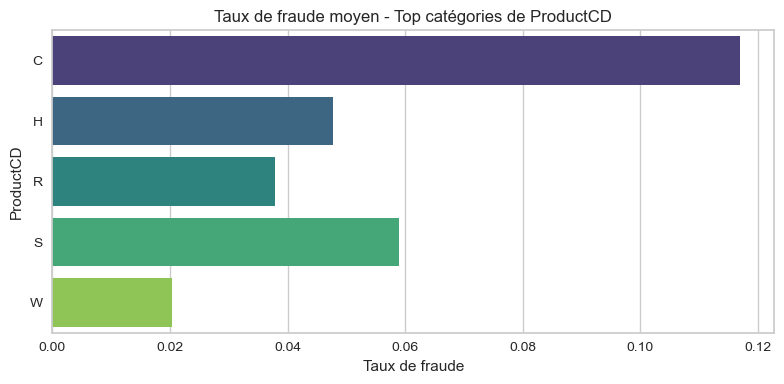

C:\Users\HP\AppData\Local\Temp\ipykernel_16120\1293572840.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate = filtered_df.groupby(col)['isFraud'].mean().reset_index()
C:\Users\HP\AppData\Local\Temp\ipykernel_16120\1293572840.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fraud_rate, x='isFraud', y=col, palette='viridis')


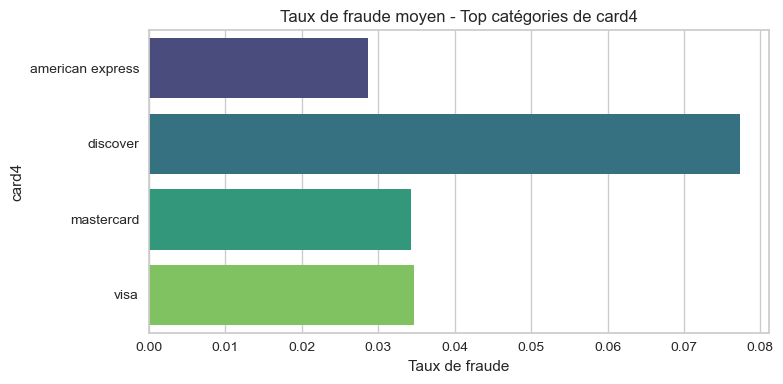

C:\Users\HP\AppData\Local\Temp\ipykernel_16120\1293572840.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate = filtered_df.groupby(col)['isFraud'].mean().reset_index()
C:\Users\HP\AppData\Local\Temp\ipykernel_16120\1293572840.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fraud_rate, x='isFraud', y=col, palette='viridis')


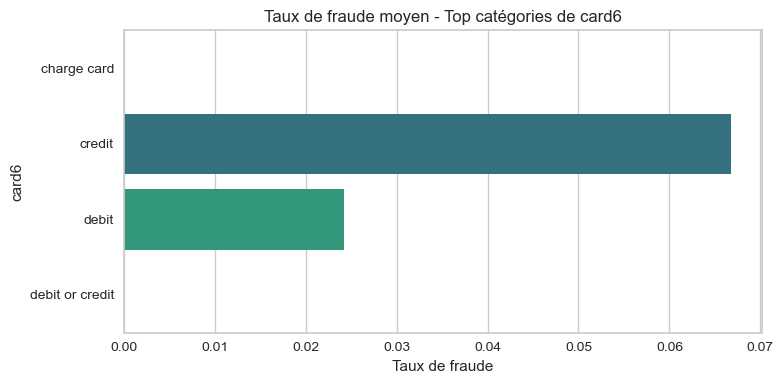

In [164]:

for col in ['card1', 'card2', 'ProductCD', 'card4', 'card6']:
    if col in df_cleaned.columns:
        # Top 10 valeurs les plus fréquentes
        top_vals = df_cleaned[col].value_counts().nlargest(10).index
        
        # Filtrer le DataFrame
        filtered_df = df_cleaned[df_cleaned[col].isin(top_vals)]
        
        # Calcul du taux de fraude
        fraud_rate = filtered_df.groupby(col)['isFraud'].mean().reset_index()
        
        # Tris dans le même ordre que top_vals
        fraud_rate[col] = pd.Categorical(fraud_rate[col], categories=top_vals, ordered=True)
        fraud_rate = fraud_rate.sort_values(by=col)

        # Plot
        plt.figure(figsize=(8, 4))
        sns.barplot(data=fraud_rate, x='isFraud', y=col, palette='viridis')
        plt.title(f"Taux de fraude moyen - Top catégories de {col}")
        plt.xlabel("Taux de fraude")
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()



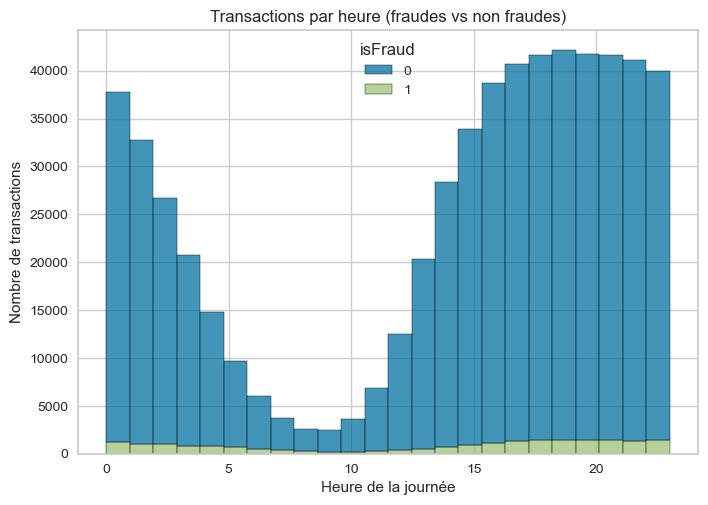

In [166]:
df_cleaned['Transaction_day'] = df_cleaned['TransactionDT'] // (3600*24)
df_cleaned['Transaction_hour'] = (df_cleaned['TransactionDT'] // 3600) % 24

# Répartition des fraudes par heure
sns.histplot(data=df_cleaned, x='Transaction_hour', hue='isFraud', bins=24, kde=False, stat="count", multiple="stack")
plt.title("Transactions par heure (fraudes vs non fraudes)")
plt.xlabel("Heure de la journée")
plt.ylabel("Nombre de transactions")
plt.show()


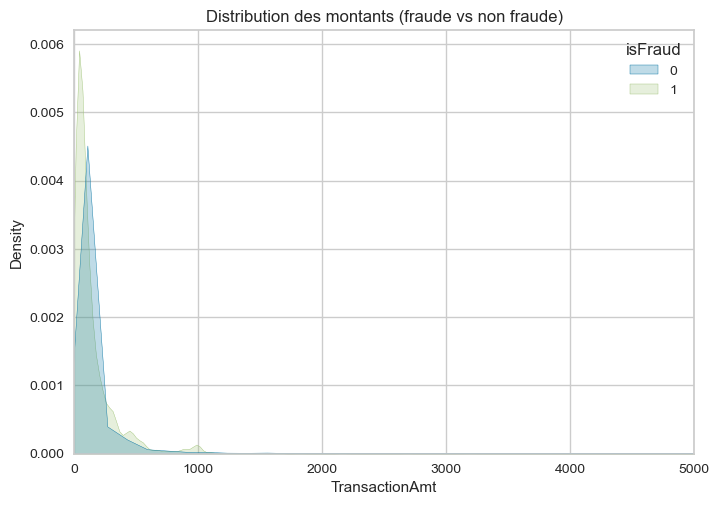

            count        mean         std    min     25%   50%    75%  \
isFraud                                                                 
0        569877.0  134.511665  239.395078  0.251  43.970  68.5  120.0   
1         20663.0  149.244779  232.212163  0.292  35.044  75.0  161.0   

               max  
isFraud             
0        31937.391  
1         5191.000  


In [167]:
sns.kdeplot(data=df_cleaned, x='TransactionAmt', hue='isFraud', common_norm=False, fill=True)
plt.xlim(0, 5000)
plt.title("Distribution des montants (fraude vs non fraude)")
plt.show()

print(df_cleaned.groupby('isFraud')['TransactionAmt'].describe())
